<a href="https://colab.research.google.com/github/snikhil17/REGex_Internship/blob/main/Team%20Project%20-%203/2_Hyper_parameter_Tuning_using_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

- It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# **Given Data**
- The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# **Acknowledgements**

- The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

# **Importing Required Libraries**

In [ ]:
# !pip install xgboost
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTETomek
import optuna
import itertools
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

## **Loading the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of creditcard_stratified.csv')
df_test= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of test.csv')
df_train.head()

id      Time        V1        V2  ...       V28  Amount  Class  kfold
0   0  171306.0  2.168118 -1.731966  ... -0.017113   52.00      0    4.0
1   1   62395.0 -0.514037  0.953548  ...  0.109626    5.85      0    4.0
2   2   43463.0 -0.671869 -0.399551  ...  0.207153   70.00      0    3.0
3   3  157918.0  2.084298  0.103235  ... -0.065743    1.00      0    1.0
4   4   67461.0  1.286755 -1.194764  ...  0.011353    5.80      0    1.0

[5 rows x 33 columns]

In [ ]:
#normal distributed outliers treatment by [min :mean-3*(sigma) or above: mean+3*(sigma)]
j=0
ND_h=[]
ND_l=[]
for i in ND_out[:]:
    m=min(df_train[i].max(),abs(df_train[i].min()))
    ND_h.append(round(df_train[i].mean() + (m-((m//5)*1.25))*df_train[i].std(),1))
    ND_l.append(round(df_train[i].mean() - (m-((m//5)*1.25))*df_train[i].std(),1))
    new_df = df_train[(df_train[i] < ND_h[j]) & (df_train[i] > ND_l[j])]
    df_train[i] = np.where( df_train[i]>ND_h[j],ND_h[j],np.where( df_train[i]<ND_l[j],  ND_l[j],  df_train[i] ))
    j=j+1

SD_out=['V1','V2','V3','V4','V5','V6','V7','V8','V11','V12','V14','V16','V17','V18','V23','V26'] #by oberving the distribution diagrams
#Skewed distribution outliers treatment
for i in SD_out[:]:
    p25 = new_df[i].quantile(0.25)
    p75 = new_df[i].quantile(0.75)
    iqr=p75-p25
    ul = p75 + 1.5 * iqr
    ll = p25 - 1.5 * iqr
    new_df1 = new_df[new_df[i] < ul]#trimming
    #capping
    new_df[i] = np.where( 
    new_df[i] > ul,
    ul,
    np.where(
        new_df[i] < ll,
        ll,
        new_df[i]
            )
    )

OD_out=['V24','V28','Amount'] #by oberving the distribution diagrams
#Other distributed outliers treatment by percentile
for i in OD_out[:]:
    upper_limit = new_df1[i].quantile(0.99)
    lower_limit = new_df1[i].quantile(0.01)
    new_df2 = new_df1[(new_df1[i] <= upper_limit) & (new_df1[i] >= lower_limit)]#trimming
    #capping
    new_df1[i] = np.where(new_df1[i] >= upper_limit,
            upper_limit,
            np.where(new_df1[i] <= lower_limit,
            lower_limit,
            new_df1[i]))

# **Taking care of Imbalanced Dataset**
## **Using ``SMOTETomek``**

In [ ]:
#Create independent and Dependent Features
columns = new_df2.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["id","Class", "kfold"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = new_df2[columns]
Y = new_df2[[target]]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(246935, 30)
(246935, 1)


## **Let's see what does SMOTETomek actually does and later we will use it again when training xtrain and testing in xvalid.**

In [ ]:
%%time
from imblearn.combine import SMOTETomek
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
col_X = list(X.columns)
col_y = list(Y.columns)
X_res,y_res=smk.fit_sample(X,Y)
X_res = pd.DataFrame(X_res, columns = col_X)
y_res = pd.DataFrame(y_res, columns = col_y)
print(X_res.shape,y_res.shape)

(492458, 30) (492458, 1)


In [ ]:
from collections import Counter
print(f'Original dataset shape {Counter(Y)}')
print(f'Resampled dataset shape {Counter(y_res)}')

# **Evaluation**
### **Confusion Matrix**

- **Confusion matrix**: A confusion matrix is a table that is often used to describe the performance of a classification model true positives (TP): These are cases in which we predicted yes.

- **true negatives (TN):** We predicted no, and they don't have the disease.

- **false positives (FP):** We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

- **false negatives (FN):** We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

- **precision** - What proportion of positive identifications was actually correct? 

- **recall** - What proportion of actual positives was identified correctly?

- **F1 Score:**
    - F1 Score is the weighted average of Precision and Recall
    - F1 is usually more useful than accuracy, especially if you have an uneven class distribution.



In [ ]:
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Hide grid lines
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Preprocessing** 

In [ ]:
# Normalizing Amount
new_df2['normalized_amount']=StandardScaler().fit_transform(new_df2['Amount'].values.reshape(-1,1))
df_test['normalized_amount'] = StandardScaler().fit_transform(df_test['Amount'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Amount'],axis=1)
df_test=df_test.drop(['Amount'],axis=1)


# Normalizing Time
new_df2['normalized_time']=StandardScaler().fit_transform(new_df2['Time'].values.reshape(-1,1))
df_test['normalized_time'] = StandardScaler().fit_transform(df_test['Time'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Time'],axis=1)
df_test=df_test.drop(['Time'],axis=1)

useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]

# **Hyperparameter Tuning**
### **Now, let’s see where will a hyperparameter optimizer stands in the whole process of learning the algorithm.**
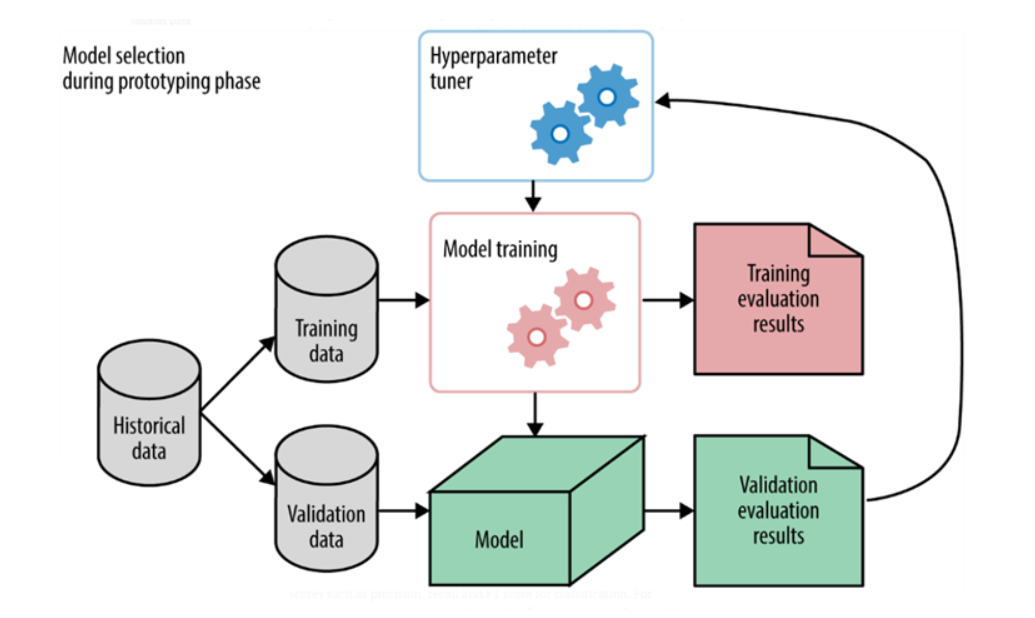

**As can be seen in the above figure, the hyperparameter tuner is external to the model and the tuning is done before model training. The result of the tuning process is the optimal values of hyperparameters which is then fed to the model training stage. Let me now introduce Optuna, an optimization library in Python that can be employed for hyperparameter optimization.**

## **Optuna**

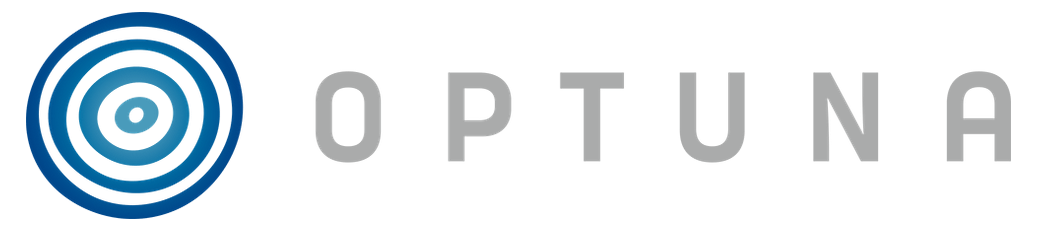

**Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms. Let me first briefly describe the different samplers available in optuna.**

- Grid Search: The search space of each hyper-parameter is discretized. The optimizer launches learning for each of the hyper-parameter configurations and selects the best at the end.
- Random: Randomly samples the search space and continues until the stopping criteria are met.
- Bayesian: Probabilistic model-based approach for finding the optimal hyperparameters
- Evolutionary algorithms: •Meta-heuristic approaches that employ the value of the fitness function to find the optimal hyperparameters.

## **Why Optuna?** 
The following features of optuna encouraged us to use it for hyperparameter tuning for the problems we were trying to solve!
- Eager dynamic search spaces
- Efficient sampling and pruning algorithms
- Easy integration
- Good visualizations
- Distributed optimization

### **Hypertuning Random Forest using Optuna**

In [ ]:
%%time
final_test_predictions = [] #to store final test predictions
final_valid_predictions = {} # to store final validation predictions
scores = [] #to store the scores

def objective(trial):
  useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
  
  for fold in range(5):                        # using for loop for 5 folds Random Forest
    xtrain =  new_df2[new_df2.kfold != fold] # Making all values which are not equal to present fold as training set
    xvalid = new_df2[new_df2.kfold == fold]  # Making all values which are equal to present fold as Validation set
    
    valid_ids = xvalid['id'].values.tolist()   # Creating keys for the dictionary containing valid predictions
    ytrain = xtrain.Class                      # creating ytrain 
    yvalid = xvalid.Class                      # creating yvalid
    xtrain = xtrain[useful_features]           # creating xtrain
    xvalid = xvalid[useful_features]           # creating xvalid
    
    smk = SMOTETomek(random_state=7)           # Implementing Oversampling for Handling Imbalanced 
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    
    # Modelling
    params =   {'n_estimators' : trial.suggest_int('n_estimators', 30, 55)
    ,'max_depth' : trial.suggest_int('max_depth', 3, 40)
    }
    model = RandomForestClassifier(**params,criterion = 'entropy',random_state= 5)
    model.fit(xtrain,ytrain)

    # Predictions and Evaluation
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc_score)

  return roc_auc_score
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=1)

[I 2021-11-12 11:28:36,302] A new study created in memory with name: no-name-d9d930d3-4493-4628-9691-765b76e687b4


0 0.9938018091673464
1 0.9858007121722765
2 0.9852559713995375
3 0.9903887698648709


[I 2021-11-12 11:35:50,164] Trial 0 finished with value: 0.9794335304342726 and parameters: {'n_estimators': 21}. Best is trial 0 with value: 0.9794335304342726.


4 0.9794335304342726
CPU times: user 7min 15s, sys: 795 ms, total: 7min 16s
Wall time: 7min 13s


In [ ]:
trial_rf = study_rf.best_trial
print('Accuracy: {}'.format(trial_rf.value))
print("Best hyperparameters: {}".format(trial_rf.params))

In [ ]:
optuna.visualization.plot_optimization_history(study_rf)

In [ ]:
optuna.visualization.plot_slice(study)

### **Hypertuning XGBoost using optuna**

In [ ]:
%%time
final_test_predictions = [] #to store final test predictions
final_valid_predictions = {} # to store final validation predictions
scores = [] #to store the scores

def objective(trial):

  
  useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]

  # using for loop for 5 folds XGBoost
  for fold in range(5):

      
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]

    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 40), 
        'n_estimators': trial.suggest_int('n_estimators', 3000, 7000), 
        'eta': trial.suggest_float('eta', 0.007, 0.013), 
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), 
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), 
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'eval_metric' : 'auc',
        'objective' : 'binary:logistic',
        }
    
    model = XGBClassifier(**params,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor", random_state=42, use_label_encoder=False)
    model.fit(xtrain,ytrain,eval_set=[(xvalid,yvalid)], early_stopping_rounds=100, verbose=500)

    preds_valid = model.predict_proba(xvalid)[:, 1]
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc_score)

  return roc_auc_score
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=5)

[I 2021-11-12 11:02:20,567] A new study created in memory with name: no-name-77d3d60e-5874-4640-8871-ba86ddeea8d6


[0]	validation_0-auc:0.92239
Will train until validation_0-auc hasn't improved in 100 rounds.
[500]	validation_0-auc:0.999463
[1000]	validation_0-auc:0.999607
Stopping. Best iteration:
[1397]	validation_0-auc:0.999658

[0]	validation_0-auc:0.904886
Will train until validation_0-auc hasn't improved in 100 rounds.
[500]	validation_0-auc:0.99781
Stopping. Best iteration:
[519]	validation_0-auc:0.997854

[0]	validation_0-auc:0.869364
Will train until validation_0-auc hasn't improved in 100 rounds.
[500]	validation_0-auc:0.995301
Stopping. Best iteration:
[883]	validation_0-auc:0.995738

[0]	validation_0-auc:0.88718
Will train until validation_0-auc hasn't improved in 100 rounds.
[500]	validation_0-auc:0.998334
Stopping. Best iteration:
[484]	validation_0-auc:0.998357

[0]	validation_0-auc:0.831368
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[213]	validation_0-auc:0.990017



[I 2021-11-12 11:10:00,183] Trial 0 finished with value: 0.9900173803116432 and parameters: {'max_depth': 18, 'n_estimators': 5600, 'eta': 0.007597877224786744, 'subsample': 0.5, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 1014.4056950052855, 'reg_lambda': 2.4913614099198647, 'reg_alpha': 25.377090112247707, 'gamma': 0.000366911162730025}. Best is trial 0 with value: 0.9900173803116432.


CPU times: user 7min 39s, sys: 2.05 s, total: 7min 41s
Wall time: 7min 39s


In [ ]:
trial_xgb = study.best_trial
print('Accuracy: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

In [ ]:
optuna.visualization.plot_optimization_history(study_xgb)

In [ ]:
optuna.visualization.plot_slice(study)

## **Hypertuning NN** 

In [ ]:
%%time
final_test_predictions = [] #to store final test predictions
final_valid_predictions = {} # to store final validation predictions
scores = [] #to store the scores

def objective(trial):  
  useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
  # using for loop for 5 folds XGBoost
  for fold in range(5):
    
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]

    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    
    #creating xtrain and xvalid 
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    
    params = {
        'alpha': trial.suggest_loguniform('alpha',1e-3,1), 
        'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes',5,15),
        'max_iter': trial.suggest_int('max_iter',30,70)}
    
    model_mp= MLPClassifier(**params,random_state=7,tol=1e-4)
    model_mp.fit(xtrain,ytrain)


    preds_valid = model_mp.predict_proba(xvalid)[:, 1]
    # final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc_score)
  return roc_auc_score
study_mp = optuna.create_study(direction='maximize')
study_mp.optimize(objective, n_trials=5)

[I 2021-11-12 10:56:04,767] A new study created in memory with name: no-name-b4e4e3c4-1037-4f16-84a8-67477f539968
[I 2021-11-12 11:01:34,086] Trial 0 finished with value: 0.9879969037313497 and parameters: {'alpha': 0.008921207867801009, 'hidden_layer_sizes': 7, 'max_iter': 50}. Best is trial 0 with value: 0.9879969037313497.


CPU times: user 5min 29s, sys: 1.62 s, total: 5min 30s
Wall time: 5min 29s


In [ ]:
trial_mp = study_mp.best_trial
print('Accuracy: {}'.format(trial_mp.value))
print("Best hyperparameters: {}".format(trial_mp.params))

Accuracy: 0.9924498506989343
Best hyperparameters: {'alpha': 0.24180626771784772, 'hidden_layer_sizes': 12, 'max_iter': 65}


In [ ]:
optuna.visualization.plot_optimization_history(study_mp)

In [ ]:
optuna.visualization.plot_slice(study_mp)